# Rubisco DMA data

In [68]:
import os
%pylab inline
import seaborn as sns
sns.set_style('ticks')
import scipy.optimize

Populating the interactive namespace from numpy and matplotlib


In [61]:
# The files have three columns: time, size, and counts. 
# In my fit, I first fitted the main peak with a Gaussian, and then used the same Gaussian but with different amplitudes 
# (given by 'guessing' a poisson parameter for droplet filling - guessing is not really correct because we know roughly droplet size and concentration)
# and progressively increasing width c(i)^2=c(1)^2*i for peak i.

In [ ]:
gaussian = lambda x, A0, x0, sigma: A0*np.exp((-(x-x0)**2)/(2.*sigma**2))
gaussians = lambda x, A0s, x0s, sigma: np.asarray([gaussian(x=x, A0=_A0, x0=_x0, sigma=sigma) for _A0, _x0 in zip(A0s, x0s)]).sum(axis=0)
gaussians_equal_sigmas = lambda x, A0s, x0, sigma: np.asarray([gaussian(x=x, A0=_A0, x0=x0*(_i+1), sigma=sigma) for _i, _A0 in enumerate(A0s)]).sum(axis=0)


def gaussians_fit(xdata=None, ydata=None, n=2, p_init=None, show=False):

    if xdata is None and ydata is None:
        # generate test data
        A0s = [7.5,10.4]
        x0s = [-5, 4.]
        sigma = 2.
        xdata = np.linspace(-20, 20, 500)
        ydata = gaussians(x=xdata, A0s=A0s, x0s=x0s, sigma=sigma)

    if p_init is None:
        A0s_init = n*[ydata.max()]
        x0s_init = [sorted(xdata)[int(round(i*xdata.size/float(n+1)))] for i in range(1,n+1)]
        sigma_init = [(xdata.max()-xdata.min())/10.]
        _p_init = A0s_init + x0s_init + sigma_init
    else:
        _p_init = p_init
    
    
    f = lambda x, p: gaussians(x, A0s=p[:len(p)/2], x0s=p[len(p)/2:2*(len(p)/2)], sigma=p[-1])
    err = lambda p: ((ydata-f(x=xdata, p=p))**2).sum()
   
    res = scipy.optimize.minimize(err, _p_init)
    
    yest = f(x=xdata, p=res.x)

    return xdata, ydata, yest

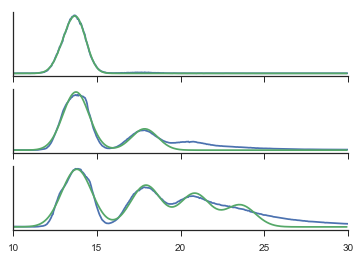

In [73]:
concs = ['5e13', '7e14', '2e15']
ips = [0, 2, 1]
times = {}
sizes = {}
counts = {}
for conc, ip in zip(concs, ips):
    fn = [os.path.join('dma_data', fn) for fn in sorted(os.listdir('dma_data')) if fn.startswith('SpR%s' % conc)][ip]
    times[conc], sizes[conc], counts[conc] = loadtxt(fn).swapaxes(0,1)
fig, axs = subplots(3, 1, sharex=True)
for conc, ax in zip(concs, axs):
    ax.plot(sizes[conc], counts[conc])
    xdata = sizes[conc].copy()
    ydata = counts[conc].copy()
    sel = (xdata>=10)*(xdata<=30)
    xdata = xdata[sel]
    ydata = ydata[sel]
    xdata, ydata, yest = gaussians_fit(xdata, ydata, n=4, p_init=None, show=False)
    ax.plot(xdata, yest)
    ax.set_xticks([10, 15, 20, 25, 30])
    ax.set_xlim(10, 30)
    ax.set_yticks([])
sns.despine()